# S-Learner

In [1]:
import pickle as pkl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import utils as utl
from tqdm import tqdm, trange
from time import time

In [2]:
data = pkl.load(open('../data/data.pkl', 'rb'))
data.head(2)

,confidence,index,time,token_path,term_match,word_net,T,Y
0,46.0,16,17.0,14.2148,12.0,11.2946,1,80
1,37.4,16,13.0,14.2148,12.0,11.2946,0,28


## Linear regression

In [3]:
def linear_regression(df, add_model=False, add_R2=False):
    xt = df[df.columns[~df.columns.isin(['Y'])]].copy()
    reg = LinearRegression().fit(xt, df['Y'])
    R2 = reg.score(xt, df['Y'])
    ts = {}
    for t in [0,1]:
        xt['T'] = t
        ts[t] = reg.predict(xt)
        
    returns = [(ts[1] - ts[0]).mean()]
    if add_model: returns.append(reg)
    if add_R2: returns.append(R2)
    return returns if len(returns)>1 else returns[0]

Linear regression (S-Learner) ATE over original data: 14.064887726451676
R2 Score: 0.18712281897856553
MSE: 706.3539745636272


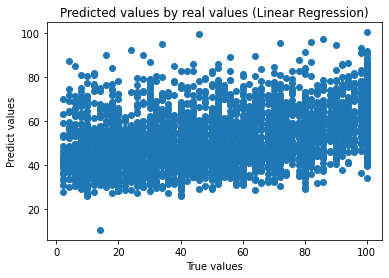

In [4]:
ATE, reg, R2 = linear_regression(data, True, True)
print(f"Linear regression (S-Learner) ATE over original data: {ATE}")
print(f"R2 Score: {R2}")
predictions = reg.predict(data[data.columns[~data.columns.isin(['Y'])]].copy())
print(f"MSE: {((data['Y'] - predictions).abs() ** 2).mean()}")
plt.scatter(data['Y'], predictions)
plt.xlabel("True values")
plt.ylabel("Predict values")
plt.title("Predicted values by real values (Linear Regression)")
plt.show()

In [5]:
linear_regression_results = utl.generate_CI(data, linear_regression, f_kwargs={}, samples=1000, alpha=0.95)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 111.19it/s]


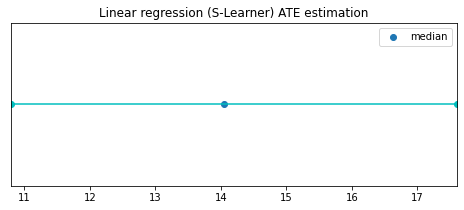

In [6]:
plt.figure(figsize=(8,3))
plot = (
            'm',
            # 'a',
        )
utl.plot_CI(**linear_regression_results, plot=plot, title='Linear regression (S-Learner) ATE estimation', xlim_l=None, xlim_u=None)

## Decision tree

In [7]:
def decision_trees(df, add_model=False, add_R2=False):
    xt = df[df.columns[~df.columns.isin(['Y'])]].copy()
    reg = DecisionTreeRegressor(max_depth=18).fit(xt, df['Y'])
    R2 = reg.score(xt, df['Y'])
    ts = {}
    for t in [0,1]:
        xt['T'] = t
        ts[t] = reg.predict(xt)
        
    returns = [(ts[1] - ts[0]).mean()]
    if add_model: returns.append(reg)
    if add_R2: returns.append(R2)
    return returns if len(returns)>1 else returns[0]

Decision tree (S-Learner) ATE over original data: 4.53969457578297
R2 Score: 0.9121173581385641


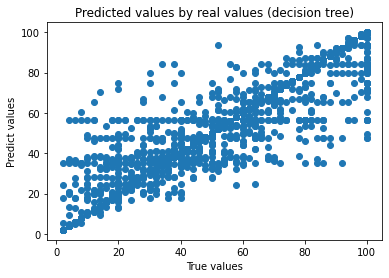

In [8]:
ATE, reg, R2 = decision_trees(data, True, True)
print(f"Decision tree (S-Learner) ATE over original data: {ATE}")
print(f"R2 Score: {R2}")
plt.scatter(data['Y'], reg.predict(data[data.columns[~data.columns.isin(['Y'])]].copy()))
plt.xlabel("True values")
plt.ylabel("Predict values")
plt.title("Predicted values by real values (decision tree)")
plt.show()

In [9]:
decision_tree_results = utl.generate_CI(data, decision_trees, f_kwargs={}, samples=1000, alpha=0.95)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 50.58it/s]


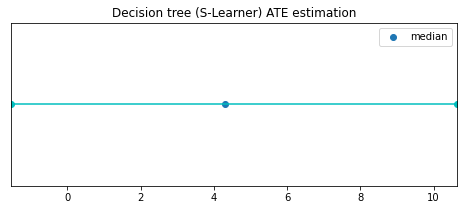

In [10]:
plt.figure(figsize=(8,3))
plot = (
            'm',
            # 'a',
        )
utl.plot_CI(**decision_tree_results, plot=plot, title='Decision tree (S-Learner) ATE estimation', xlim_l=None, xlim_u=None)

## Neural Network

In [11]:
import torch
from torch import nn, optim

In [12]:
def MLP(df, time_lim=7.2, epoch_lim=1000, add_model=False, add_loss=False, apply_tqdm=True):
    nn_0 = nn.Sequential(*[nn.Linear(7, 128),
                         nn.ReLU(),
                         nn.Linear(128,512),
                         nn.ReLU(),
                         nn.Linear(512,1)])

    loss_0 = nn.MSELoss()
    optimizer_0 = optim.Adam(nn_0.parameters(), lr=0.03)

    x_0 = df[df.columns[~df.columns.isin(['Y'])]].values
    y_0 = df['Y'].astype(float).values
    x_0_tensor = torch.from_numpy(x_0).to(dtype=torch.float)
    y_0_tensor = torch.from_numpy(y_0).to(dtype=torch.float)

    start = time()
    losses = []
    pbar = trange(epoch_lim) if apply_tqdm else range(epoch_lim)
    for e in pbar:
        if time_lim is not None and time()-start > time_lim: break
        optimizer_0.zero_grad()
        preds_0 = nn_0(x_0_tensor)
        loss_0_item = loss_0(preds_0.squeeze(), y_0_tensor)
        loss_0_item.backward()
        optimizer_0.step()

        loss = loss_0_item.item()
        losses.append(loss)
        if apply_tqdm: pbar.set_description(f"loss={round(loss,2)}")

    ts = {}
    for t in [0,1]:
        x_0_tensor[:, -1] = t
        ts[t] = nn_0(x_0_tensor).squeeze().detach().numpy()

    returns = [(ts[1] - ts[0]).mean()]
    if add_model: returns.append(nn_0)
    if add_loss: returns.append(losses)
    return returns if len(returns)>1 else returns[0]

loss=531.43: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [04:40<00:00, 17.81it/s]


MLP (S-Learner) ATE over original data: 11.95505428314209
last loss: 531.4290161132812


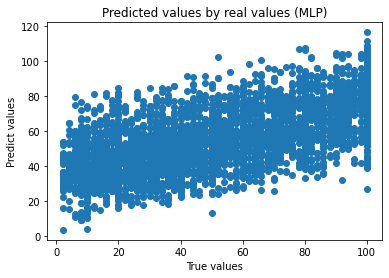

In [13]:
ATE, my_nn, losses = MLP(data, time_lim=None, epoch_lim=5000, add_model=True, add_loss=True)
print(f"MLP (S-Learner) ATE over original data: {ATE}")
print(f"last loss: {losses[-1]}")
tensor_data = torch.from_numpy(data[data.columns[~data.columns.isin(['Y'])]].copy().values).to(dtype=torch.float)
predictions = my_nn(tensor_data).squeeze().detach().numpy()
plt.scatter(data['Y'],predictions)
plt.xlabel("True values")
plt.ylabel("Predict values")
plt.title("Predicted values by real values (MLP)")
plt.show()

In [14]:
total_mins_allowed = 120
bootstrap_samples = 500
time_lim = total_mins_allowed*60/bootstrap_samples
f_kwargs = {'time_lim':time_lim, 'epoch_lim':1000, 'add_model':False, 'add_loss':False, 'apply_tqdm':False}
MLP_results = utl.generate_CI(data, MLP, f_kwargs=f_kwargs, samples=bootstrap_samples, alpha=0.95)

100%|██████████████████████████████████████████████████████████████████████████████| 500/500 [2:00:31<00:00, 14.46s/it]


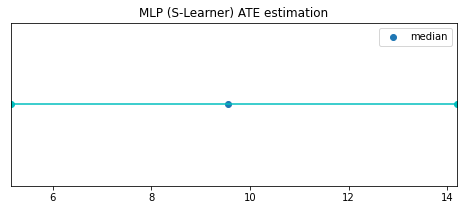

In [18]:
plt.figure(figsize=(8,3))
plot = (
            'm',
            # 'a',
        )
utl.plot_CI(**MLP_results, plot=plot, title='MLP (S-Learner) ATE estimation', xlim_l=None, xlim_u=None)

## Saving

In [17]:
save = True
saving_list = [(linear_regression_results, 'LR S-learner'),
               (decision_tree_results, 'DT S-learner'),
               (MLP_results, 'DL S-learner')]
if save:
    for var, name in saving_list:
        pkl.dump(var, open(f'../results/{name}', 'wb'))